## ◼제주도 관광지 추천 시스템

- 시스템 동작 과정
  - 테마 선택
  - 세부사항 선택 : 대표 장소, 관광지 수 입력
    - 관광지 : 이미지 선택
    - 음식점, 카페 : 이미지 선택 -> CLIP을 활용한 라벨 이용?  
  - 관광지 추천 : 유사도, 평점 등을 활용하여 관광지 추천
  - 최적 경로 탐색 : 추천된 관광지 최적 경로 탐색

In [293]:
# 사용 라이브러리
import json
import requests
import folium
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import set_matplotlib_korean
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm

In [142]:
# 파일 Path 및 주요 키워드
img_home = './data/220122/종합_이미지/'

img_euclidean_path = './data/220124/_image_euclidean_dist.npy'

jeju_poi_path = './data/220124/_종합_POI_주변관광지_추가.xlsx'

keywords = {'1' : '테마파크',
            '2' : '감성',
            '3' : '오션뷰',
            '4' : '레포츠',
            '5' : '맛집',
            '6' : '체험',
            '7' : '가족여행',
            '8' : '분위기 좋은',
            '9' : '가볼만한 곳'}

categories = {'1' : '관광명소',
              '2' : '음식점',
              '3' : '카페',}

poi_list = ['관광명소', '음식점', '카페']

### 1. 테마 선택

- 키워드(9개) : '테마파크', '감성', '오션뷰', '레포츠', '맛집', '체험', '가족여행', '분위기 좋은', '가볼만한 곳'
- 카테고리 그룹(3개) : '관광명소', '음식점', '카페'

#### ◽관광지 수 입력

In [ ]:
poi_count = {}

print('관광명소, 음식점, 카페 개수 선택. 공백으로 나누어 입력.')
print('-'*60)
for idx, poi in enumerate(poi_list):
    print('\t{}. {} 개수\t: '.format(idx+1, poi), end = '')
    poi_count[poi] = int(input())
    print('{}개'.format(poi_count[poi]))
print('-'*60)

관광명소, 음식점, 카페 개수 선택. 공백으로 나누어 입력.
------------------------------------------------------------
	1. 관광명소 개수	: 2개
	2. 음식점 개수	: 0개
	3. 카페 개수	: 0개
------------------------------------------------------------


#### ◽키워드 선택

In [156]:
keyword_result = {}

print('키워드를 선택해주시기 바랍니다. 복수 선택시 공백(space)으로 구분')
print('-'*60)
for key, value in keywords.items():
    print('\t{}. {}'.format(key, value))
print('-'*60)
for key, value in poi_count.items():
    if value != 0:
        print('[{}] 키워드 입력(번호 선택) : '.format(key), end ='')
        keyword_nums = input().split(' ')
        keyword_result[key] = [keywords[key] for key in keyword_nums]
        print(keyword_nums, '-', keyword_result[key])

키워드를 선택해주시기 바랍니다. 복수 선택시 공백(space)으로 구분
------------------------------------------------------------
	1. 테마파크
	2. 감성
	3. 오션뷰
	4. 레포츠
	5. 맛집
	6. 체험
	7. 가족여행
	8. 분위기 좋은
	9. 가볼만한 곳
------------------------------------------------------------
[관광명소] 키워드 입력(번호 선택) : ['1', '2', '3'] - ['테마파크', '감성', '오션뷰']


#### ◽코사인 유사도 확인

##### 자연어 코사인 유사도 함수

- 입력값에 대한 코사인 유사도 반환 함수

In [158]:
# content, 입력값의 count_vector matrix 반환 함수
# keyword : 입력받은 키워드 리스트
# category : 입력받은 카테고리 리스트
# content : 장소 정보의 'content' 컬럼
#           - content : keyword + category_group_name
def get_count_mat(keyword, category, content):
    # content를 이용해 count_vector 학습
    count_vect = CountVectorizer(min_df = 0, ngram_range=(1, 2))
    content_mat = count_vect.fit_transform(content)
    input_result = keyword.copy()
    input_result.append(category)
    # count vecter를 위해 각 단어의 공백(space) 삭제
    input_result = [input_str.replace(' ', '') for input_str in input_result]
    # input_result를 이용해 count_vector 생성
    input_mat = count_vect.transform([' '.join(input_result)])

    return input_mat, content_mat


In [159]:
# input_mat 기준 sim_mat의 유사도 결과 반환
# DataFrame의 컬럼으로 추가하기 위해 reshape하여 반환
def get_cosine_sim(input_mat, sim_mat):
    input_sim = cosine_similarity(input_mat, sim_mat)
    return input_sim.reshape(-1, 1)

In [173]:
# content(keyword + category_group_name) 기준 코사인 상위 Top20 반환
# original : 코사인 유사도를 구할 원본 Dataframe
# keyword_result : 카테고리명을 key로 입력받은 keyword들을 value로 가지는 Dict
# key : 코사인 유사도를 구할 카테고리명
def get_cosine_top20(original, keyword_result, key):
    if key in keyword_result:
        # 코사인 유사도 획득
        input_mat, content_mat = get_count_mat(keyword_result[key], key, original['content'])
        input_sim = get_cosine_sim(input_mat, content_mat)
        # 코사인 유사도 컬럼 추가
        original['input_sim'] = input_sim
        # 유사도 결과 Top 20 반환
        return original.query(f'category_group_name == "{key}"').sort_values('input_sim', ascending=False).iloc[:20, :]

- 장소 정보(원본 데이터) 읽기

In [174]:
jeju_poi = pd.read_excel(jeju_poi_path, index_col=False)

In [175]:
jeju_poi.head(1)

,idx,keyword,address_name,category_group_name,category_name,id,place_name,x,y,rating,kind,content,adjacent_tour,adjacent_rest,adjacent_cafe
0,0,테마파크,제주특별자치도 제주시 연동 1320,관광명소,"문화,예술 > 문화시설 > 박물관",26388484,수목원테마파크 아이스뮤지엄,126.488398,33.470777,1.0,제주시,테마파크 관광명소,29,268,138


##### (1) 관광명소

In [183]:
tour_poi = get_cosine_top20(jeju_poi, keyword_result, "관광명소")
if tour_poi is not None:
    tour_poi = tour_poi.reset_index(drop=True)

In [184]:
tour_poi.head(1)

,idx,keyword,address_name,category_group_name,category_name,id,place_name,x,y,rating,kind,content,adjacent_tour,adjacent_rest,adjacent_cafe,input_sim
0,0,테마파크,제주특별자치도 제주시 연동 1320,관광명소,"문화,예술 > 문화시설 > 박물관",26388484,수목원테마파크 아이스뮤지엄,126.488398,33.470777,1.0,제주시,테마파크 관광명소,29,268,138,0.57735


##### (2) 음식점

In [185]:
rest_poi = get_cosine_top20(jeju_poi, keyword_result, "음식점")
if rest_poi is not None:
    rest_poi = rest_poi.reset_index(drop=True)

In [ ]:
rest_poi.head(1)

##### (3) 카페

In [186]:
cafe_poi = get_cosine_top20(jeju_poi, keyword_result, "카페")
if cafe_poi is not None:
    cafe_poi = cafe_poi.reset_index(drop=True)

In [ ]:
cafe_poi.head(1)

### 2. 세부 사항 선택 : 대표 선택

#### ◽관광명소 대표 장소 선택

##### (1) Top 20 확인

In [187]:
if '관광명소' in keyword_result:
    print(keyword_result['관광명소'])
else:
    print('관광명소를 추천하지 않습니다.')

['테마파크', '감성', '오션뷰']


In [188]:
tour_poi[['place_name', 'content', 'input_sim']]

,place_name,content,input_sim
0,수목원테마파크 아이스뮤지엄,테마파크 관광명소,0.577350
1,제주거울미로 이상한나라의 앨리스,테마파크 관광명소,0.577350
2,파더스가든,테마파크 관광명소,0.577350
3,다이나믹메이즈 제주도성읍점,테마파크 관광명소,0.577350
4,신화워터파크,테마파크 관광명소,0.577350
5,금호리조트 제주아쿠아나,테마파크 관광명소,0.577350
6,소인국테마파크,테마파크 관광명소,0.577350
7,뽀로로앤타요테마파크 제주,테마파크 관광명소,0.577350
8,마린파크,테마파크 관광명소,0.577350
9,산방산랜드,테마파크 관광명소,0.577350


##### (2) 대표 장소 선정

In [213]:
if poi_count['관광명소'] == 0:
    tour_result = None

- 각 장소의 대표 이미지를 보여주고 장소 선택
- **선택한 장소를 기준으로 다른 장소 추천**

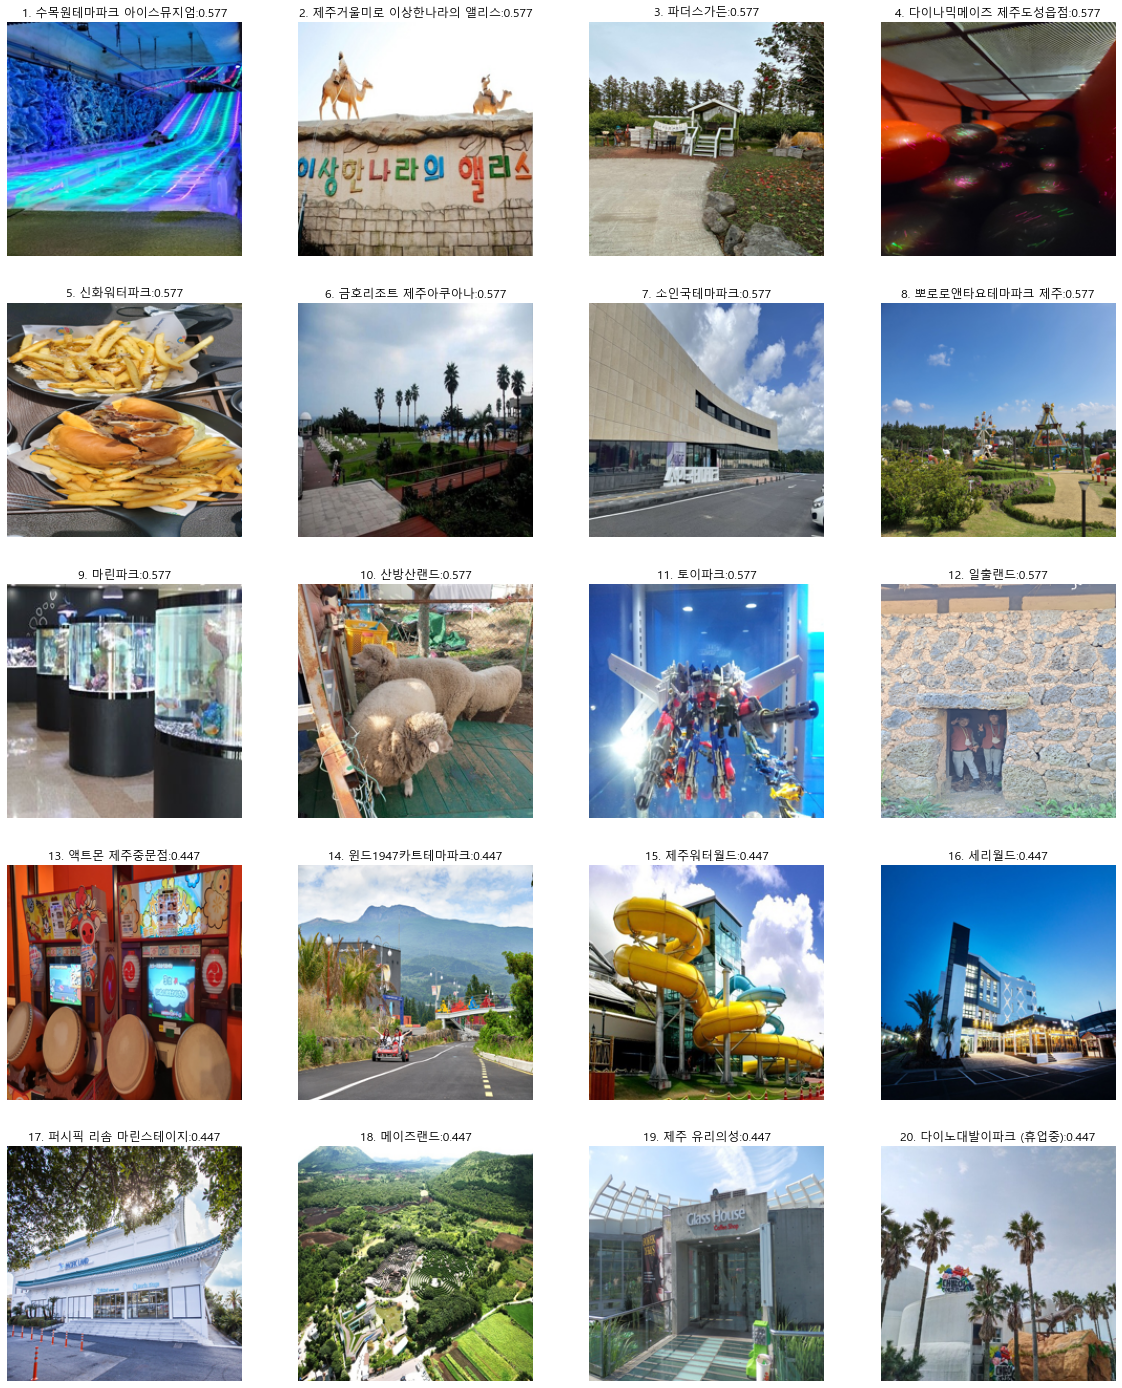

In [204]:
tour_img_info = {}
plt.figure(figsize=(20, 25))
cnt = 1
for idx, row in tour_poi.iterrows():
    plt.subplot(5, 4, cnt)
    img_path = img_home + row['category_group_name'] + '/'+str(row['id'])+'_'+row['place_name']+'.png'
    img = plt.imread(img_path)
    plt.imshow(img)
    title = str(cnt) + '. ' + row['place_name'] + ':' + str(round(row['input_sim'], 3))
    plt.gca().set_title(title)
    plt.axis(False)
    tour_img_info[str(cnt)] = [row['id'], row['place_name'], round(row['input_sim'], 3)]
    cnt += 1
plt.show()

In [206]:
print('대표 장소를 선택해주시기 바랍니다. 1개만 선택')
print('-'*60)
for key, value in tour_img_info.items():
    print('\t{}. {}'.format(key, value))
print('-'*60)
print('입력(번호 선택) : ', end='')
tour_num = input()
tour_result = tour_img_info[tour_num]
print(tour_num, '-', tour_result)

대표 장소를 선택해주시기 바랍니다. 1개만 선택
------------------------------------------------------------
	1. [26388484, '수목원테마파크 아이스뮤지엄', 0.577]
	2. [12520358, '제주거울미로 이상한나라의 앨리스', 0.577]
	3. [303901411, '파더스가든', 0.577]
	4. [1527411751, '다이나믹메이즈 제주도성읍점', 0.577]
	5. [1870273669, '신화워터파크', 0.577]
	6. [12665029, '금호리조트 제주아쿠아나', 0.577]
	7. [11330871, '소인국테마파크', 0.577]
	8. [942616668, '뽀로로앤타요테마파크 제주', 0.577]
	9. [9720913, '마린파크', 0.577]
	10. [11059651, '산방산랜드', 0.577]
	11. [17630155, '토이파크', 0.577]
	12. [10399499, '일출랜드', 0.577]
	13. [780499262, '액트몬 제주중문점', 0.447]
	14. [820826091, '윈드1947카트테마파크', 0.447]
	15. [17150892, '제주워터월드', 0.447]
	16. [10472331, '세리월드', 0.447]
	17. [10880885, '퍼시픽 리솜 마린스테이지', 0.447]
	18. [13095815, '메이즈랜드', 0.447]
	19. [8064310, '제주 유리의성', 0.447]
	20. [107991673, '다이노대발이파크 (휴업중)', 0.447]
------------------------------------------------------------
입력(번호 선택) : 1 - [26388484, '수목원테마파크 아이스뮤지엄', 0.577]


#### ◽음식점 대표 장소 선택

##### (1) Top 20 확인

In [179]:
if '음식점' in keyword_result:
    print(keyword_result['음식점'])
else:
    print('음식점을 추천하지 않습니다.')

음식점를 추천하지 않습니다.


In [ ]:
rest_poi[['place_name', 'content', 'input_sim']]

##### (2) 대표 장소 선정

- 각 장소의 대표 이미지를 보여주고 장소 선택
- **선택한 장소를 기준으로 다른 장소 추천**

In [214]:
if poi_count['음식점'] == 0:
    rest_result = None

In [ ]:
rest_img_info = {}
plt.figure(figsize=(20, 25))
cnt = 1
for idx, row in rest_poi.iterrows():
    plt.subplot(5, 4, cnt)
    img_path = img_home + row['category_group_name'] + '/'+str(row['id'])+'_'+row['place_name']+'.png'
    img = plt.imread(img_path)
    plt.imshow(img)
    title = str(cnt) + '. ' + row['place_name'] + ':' + str(round(row['input_sim'], 3))
    plt.gca().set_title(title)
    plt.axis(False)
    rest_img_info[str(cnt)] = [row['id'], row['place_name'], round(row['input_sim'], 3)]
    cnt += 1
plt.show()

In [ ]:
print('대표 장소를 선택해주시기 바랍니다. 1개만 선택')
print('-'*60)
for key, value in rest_img_info.items():
    print('\t{}. {}'.format(key, value))
print('-'*60)
print('입력(번호 선택) : ', end='')
rest_num = input()
rest_result = rest_img_info[rest_num]
print(rest_num, '-', rest_result)

#### ◽카페 대표 장소 선택

##### (1) Top 20 확인

In [180]:
if '카페' in keyword_result:
    print(keyword_result['카페'])
else:
    print('카페를 추천하지 않습니다.')

카페를 추천하지 않습니다.


In [ ]:
cafe_poi[['place_name', 'content', 'input_sim']]

##### (2) 대표 장소 선정

In [215]:
if poi_count['카페'] == 0:
    cafe_result = None

- 각 장소의 대표 이미지를 보여주고 장소 선택
- **선택한 장소를 기준으로 다른 장소 추천**

In [ ]:
cafe_img_info = {}
plt.figure(figsize=(20, 25))
cnt = 1
for idx, row in cafe_poi.iterrows():
    plt.subplot(5, 4, cnt)
    img_path = img_home + row['category_group_name'] + '/'+str(row['id'])+'_'+row['place_name']+'.png'
    img = plt.imread(img_path)
    plt.imshow(img)
    title = str(cnt) + '. ' + row['place_name'] + ':' + str(round(row['input_sim'], 3))
    plt.gca().set_title(title)
    plt.axis(False)
    cafe_img_info[str(cnt)] = [row['id'], row['place_name'], round(row['input_sim'], 3)]
    cnt += 1
plt.show()

In [ ]:
print('대표 장소를 선택해주시기 바랍니다. 1개만 선택')
print('-'*60)
for key, value in cafe_img_info.items():
    print('\t{}. {}'.format(key, value))
print('-'*60)
print('입력(번호 선택) : ', end='')
cafe_num = input()
cafe_result = cafe_img_info[cafe_num]
print(cafe_num, '-', cafe_result)

### 3. 관광지 추천

#### ◽관광명소 추천

- 유클리드 거리, 평점 기준으로 순위 선정

In [201]:
# count만큼의 관광명소를 추천하는 함수
# 유클리드 거리와 평점을 기준으로 선정
# poi_df : 전체 장소 DataFrame
# select_item : 대표로 선정한 관광명소
# count : 관광명소 추천 개수
def recommand_tourism(poi_df, select_item, count):
    if count == 0 :
        return None
    tour_df = poi_df.query('category_group_name == "관광명소"').reset_index(drop=True)
    img_euclidean_dist = np.load(img_euclidean_path)

    idx = tour_df[tour_df['id'] == select_item[0]].index[0]
    tour_df['img_euclidean_dist'] = img_euclidean_dist[idx]
    top20 = tour_df.sort_values('img_euclidean_dist', ascending=True).iloc[:20, :]

    return top20.sort_values('rating', ascending=False).iloc[:count]


In [202]:
tourism = recommand_tourism(jeju_poi, tour_result, poi_count['관광명소'])

In [203]:
tourism[['id', 'place_name', 'rating', 'img_euclidean_dist', 'x', 'y']]

,id,place_name,rating,img_euclidean_dist,x,y
23,13725673,수산봉둘레길,5.0,1.160116,126.381975,33.473535
106,10271092,큰노꼬메오름,4.9,1.182774,126.411458,33.389128


#### ◽음식점 추천 : 미완성

In [218]:
# count만큼의 음식점을 추천하는 함수
# poi_df : 전체 장소 DataFrame
# select_item : 대표로 선정한 음식점
# count : 음식점 추천 개수
def recommand_rest(poi_df, select_item, count):
    if count == 0 :
        return None
    rest_df = poi_df.query('category_group_name == "음식점"').reset_index(drop=True)

    idx = rest_df[rest_df['id'] == select_item[0]].index[0]
    top20 = rest_df.sort_values('', ascending=True).iloc[:20, :]

    return top20.sort_values('rating', ascending=False).iloc[:count]


In [219]:
restaurant = recommand_rest(jeju_poi, rest_result, poi_count['음식점'])

#### ◽카페 추천 : 미완성

In [220]:
# count만큼의 카페를 추천하는 함수
# poi_df : 전체 장소 DataFrame
# select_item : 대표로 선정한 카페
# count : 카페 추천 개수
def recommand_cafe(poi_df, select_item, count):
    if count == 0 :
        return None
    cafe_df = poi_df.query('category_group_name == "카페"').reset_index(drop=True)

    idx = cafe_df[cafe_df['id'] == select_item[0]].index[0]
    top20 = cafe_df.sort_values('', ascending=True).iloc[:20, :]

    return top20.sort_values('rating', ascending=False).iloc[:count]


In [221]:
cafe = recommand_cafe(jeju_poi, rest_result, poi_count['카페'])

### 4. 최적 경로 탐색

#### ◽추천 관광지 종합

In [230]:
columns = ['id', 'place_name', 'address_name', 'x', 'y']
recommand_result = pd.DataFrame(columns=columns)
if tourism is not None:
    recommand_result = recommand_result.append(tourism[columns])
if restaurant is not None:
    recommand_result = recommand_result.append(restaurant[columns])
if cafe is not None:
    recommand_result = recommand_result.append(cafe[columns])

In [231]:
recommand_result

,id,place_name,address_name,x,y
23,13725673,수산봉둘레길,제주특별자치도 제주시 애월읍 구엄리,126.381975,33.473535
106,10271092,큰노꼬메오름,제주특별자치도 제주시 애월읍 유수암리 산 138,126.411458,33.389128


#### ◽최적 경로 탐색

- 카카오 네비게이션 API 기준 가장 시간이 짧게 걸리는 경우 선택
- 자동차 길찾기
  - 네비게이션 길안내 결과 반환
- 제한 사항 : <a href='https://developers.kakao.com/terms/latest/ko/site-policies#quota' target='_blink'>링크</a>
  - 월간 제공량 : 전체 API 3,000,000건
  - 일간 제공량 : 카카오내비(REST API) 자동차 길찾기 10,000건

---
- origin : 33.248678, 126.56734
- destiantion : 33.291055, 126.461936
- 한라산 : 33.361204769954284, 126.53111502985787
---
- 경로 탐색 실패하는 경우 발생 : **출발지, 도착지 주변에 도로가 없는 경우**

##### 경로 탐색 함수

In [274]:
def search_route(routes):
    # REST 키
    rest_api_key = '63d0926cf9b14de298157081ba8a8d02'
    # 헤더
    headers = {"Authorization" : "KakaoAK {}".format(rest_api_key)}
    origin = routes[0]
    destination = routes[-1]
    waypoints = '|'.join(routes[1:-1])
    print(origin)
    print(destination)
    print(waypoints)
    # 파라미터
    # origin, destination : x, y
    # waypoints : x, y| x, y|...
    url = "https://apis-navi.kakaomobility.com/v1/directions?origin={}&destination={}&waypoints={}&priority=RECOMMEND&car_fuel=GASOLINE&car_hipass=false&alternatives=false&road_details=false".format(origin, destination, waypoints)

    # GET을 이용하여 획득
    res = requests.get(url, headers=headers)
    # Json을 이용하여 해제
    doc = json.loads(res.text)
    
    # 200일 경우 정상
    return res.status_code, doc

In [290]:
def get_vertexes(doc):
    vertexes = []
    for road in doc['routes'][0]['sections'][0]['roads']:
        test_v = road['vertexes']
        for i in range(0, len(test_v), 2):
            vertexes.append((test_v[i+1], test_v[i]))
    return vertexes

In [286]:
test_result = []
for x, y in recommand_result[['x', 'y']].values:
    test_result.append(str(x)+', '+str(y))

In [287]:
test_result

['126.381974618862, 33.4735345098889', '126.4114582010665, 33.38912818170841']

In [288]:
status, doc = search_route(test_result)

126.381974618862, 33.4735345098889
126.4114582010665, 33.38912818170841



In [289]:
status, doc

(200,
 {'trans_id': '0134162204124cf3ab2f2bfa2e91fef9',
  'routes': [{'result_code': 103, 'result_msg': '도착지점 주변의 도로를 탐색할 수 없음'}]})

In [292]:
vertexes = None
if doc['routes'][0]['result_code'] == 0:
    vertexes = get_vertexes(doc)
else:
    print('경로 탐색 실패')

경로 탐색 실패


### 5. 최적 경로 출력

#### ◽경로 표현

In [ ]:
origin = doc['routes'][0]['summary']['origin']
waypoints = doc['routes'][0]['summary']['waypoints']
destination = doc['routes'][0]['summary']['destination']

map = folium.Map(location=[origin['y'], origin['x']], zoom_start=9)
folium.Marker(location=[origin['y'], origin['x']], popup='origin').add_to(map)
folium.Marker(location=[destination['y'], destination['x']], popup='destination').add_to(map)
folium.PolyLine(vertexes, color='red').add_to(map)
map